In [2]:
import anndata as ad
import pandas as pd
import scipy.sparse as sparse
import pycisTopic
import numpy as np
import os

/home/lab/miniconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
# Check the version 
pycisTopic.__version__

'2.0a0'

# 1. Load the AnnData file

In [4]:
# The AnnData object (adata), which holds your Seurat data (already filtered). 
adata = ad.read_h5ad("data/cistopic_wt.h5ad")

# 2. Inspect the object

In [5]:
# cell metadata
print(adata.obs.head(10))

                       orig.ident  nCount_ATAC  nFeature_ATAC  \
ctl_AAACAGCCAAACGGGC-1       sm23      30069.0          16842   
ctl_AAACAGCCAAAGCTCC-1       sm23       7631.0           6120   
ctl_AAACAGCCAATGAGGT-1       sm23      15093.0          10230   
ctl_AAACATGCAAACCTAT-1       sm23      16107.0          11039   
ctl_AAACATGCACAAAGCG-1       sm23      16578.0          11573   
ctl_AAACATGCATAACGGG-1       sm23      34382.0          18268   
ctl_AAACCAACAGTAAAGC-1       sm23      26613.0          17298   
ctl_AAACCGAAGAGCCGCT-1       sm23      16081.0          11044   
ctl_AAACCGAAGGCAGGTG-1       sm23      18505.0          12280   
ctl_AAACCGAAGGGCCATC-1       sm23      62916.0          25970   

                               gex_barcode        atac_barcode  is_cell  \
ctl_AAACAGCCAAACGGGC-1  AAACAGCCAAACGGGC-1  ACAGCGGGTAGGTGAC-1        1   
ctl_AAACAGCCAAAGCTCC-1  AAACAGCCAAAGCTCC-1  ACAGCGGGTCATGATC-1        1   
ctl_AAACAGCCAATGAGGT-1  AAACAGCCAATGAGGT-1  ACAGCGGGTCGCAAT

In [6]:
# check the count matrix 
print(adata.X[:10, :5]) 
# matrix is sparse, so it will only show those coordinates of the first ten rows and 5 columns where their values are not zero 

  (4, 3)	2.360254472110471
  (9, 3)	1.2606943314767471


In [7]:
print(adata.var_names.is_unique)

True


In [8]:
from pycisTopic.cistopic_class import CistopicObject

matrix = adata.X
cells = adata.obs_names
peaks = adata.var_names
cell_data = adata.obs

#print(matrix[:5, :5])  # first 5 cells × first 5 peaks
#print(cells[:5])  # first 5 cell names
#print(peaks[:5])  # first 5 peak names

print(cell_data.iloc[:5, :5])  # first 5 rows and first 5 columns

                       orig.ident  nCount_ATAC  nFeature_ATAC  \
ctl_AAACAGCCAAACGGGC-1       sm23      30069.0          16842   
ctl_AAACAGCCAAAGCTCC-1       sm23       7631.0           6120   
ctl_AAACAGCCAATGAGGT-1       sm23      15093.0          10230   
ctl_AAACATGCAAACCTAT-1       sm23      16107.0          11039   
ctl_AAACATGCACAAAGCG-1       sm23      16578.0          11573   

                               gex_barcode        atac_barcode  
ctl_AAACAGCCAAACGGGC-1  AAACAGCCAAACGGGC-1  ACAGCGGGTAGGTGAC-1  
ctl_AAACAGCCAAAGCTCC-1  AAACAGCCAAAGCTCC-1  ACAGCGGGTCATGATC-1  
ctl_AAACAGCCAATGAGGT-1  AAACAGCCAATGAGGT-1  ACAGCGGGTCGCAATT-1  
ctl_AAACATGCAAACCTAT-1  AAACATGCAAACCTAT-1  CATTTAGGTGCGCGAA-1  
ctl_AAACATGCACAAAGCG-1  AAACATGCACAAAGCG-1  CATTTAGGTACAAACG-1  


In [9]:
binary_matrix = (matrix > 0).astype(int)

# 3. Create the Cistopic object

In [10]:
cobj = CistopicObject(
    fragment_matrix = matrix,
    binary_matrix = binary_matrix,
    cell_names = list(cells),
    region_names = list(peaks),
    cell_data = cell_data,
    region_data = None,
    path_to_fragments = "data/atac_fragments.tsv.gz"
)

cobj

# 4. Running Scrublet

We can run Scrublet on the fragment count matrix to infer doublets from the scATAC-seq.

(Although it is raising some errors, it is generating the plots) 

Preprocessing...


/home/lab/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scrublet/helper_functions.py:321: RuntimeWarning: divide by zero encountered in divide
  w.setdiag(float(target_total) / tots_use)
/home/lab/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 185.4 seconds
Detected doublet rate = 11.3%
Estimated detectable doublet fraction = 31.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 36.0%


ValueError: 5011 columns passed, passed data had 110732 columns

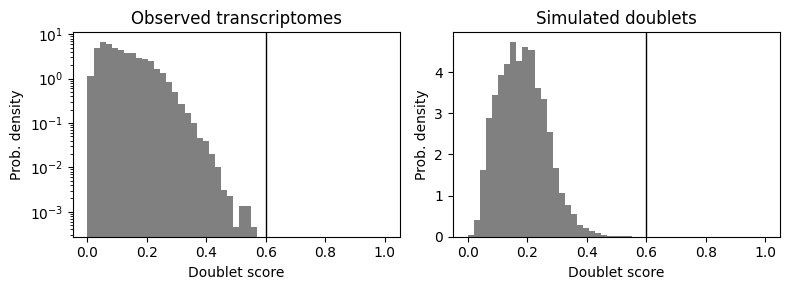

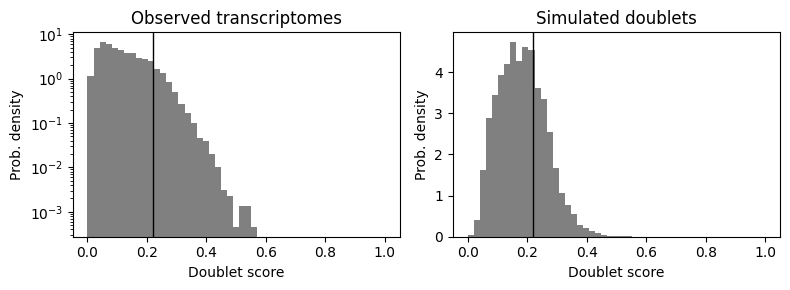

In [10]:
import scrublet as scr
scrub = scr.Scrublet(cobj.fragment_matrix.T, expected_doublet_rate=0.1)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram();
scrub.call_doublets(threshold=0.22)
scrub.plot_histogram();
scrublet = pd.DataFrame([scrub.doublet_scores_obs_, scrub.predicted_doublets_], columns=cobj.cell_names, index=['Doublet_scores_fragments', 'Predicted_doublets_fragments']).T

# 5. Parallel LDA with MALLET

We need the binary in order to use Mallet: 

In [1]:
!wget https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
!tar -xf Mallet-202108-bin.tar.gz

--2025-12-10 15:43:23--  https://github.com/mimno/Mallet/releases/download/v202108/Mallet-202108-bin.tar.gz
Resolviendo github.com (github.com)... 140.82.121.4
Conectando con github.com (github.com)[140.82.121.4]:443... conectado.
Petición HTTP enviada, esperando respuesta... 302 Found
Ubicación: https://release-assets.githubusercontent.com/github-production-release-asset/18378040/6a3fdbe6-0d3f-4f99-add3-1f98129f43cb?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-10T15%3A25%3A45Z&rscd=attachment%3B+filename%3DMallet-202108-bin.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-10T14%3A25%3A15Z&ske=2025-12-10T15%3A25%3A45Z&sks=b&skv=2018-11-09&sig=e3KvEzY9VSI3lGLZkYLtaQFWdo61ltXDbwnssZusaX0%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NTM3ODEwNCwibmJmIjoxNzY1Mzc3ODA0LCJwYXRoIjoicmVsZWFzZWFzc

In [51]:
!mkdir -p scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/
!mkdir -p scratch/leuven/330/vsc33053/ray_spill/mallet/save/

We ran several topic models (each with different number of topics) to infer the optimal number. (error here)


In [24]:
os.environ['MALLET_MEMORY'] = '200G'
from pycisTopic.lda_models import run_cgs_models_mallet
# Configure path Mallet
mallet_path="Mallet-202108/bin/mallet"
# Run models
models=run_cgs_models_mallet(
    cobj,
    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    n_cpu=12,
    n_iter=500,
    random_state=555,
    alpha=50,
    alpha_by_topic=True,
    eta=0.1,
    eta_by_topic=False,
    tmp_path="scratch/leuven/330/vsc33053/ray_spill/mallet/tmp",
    save_path="scratch/leuven/330/vsc33053/ray_spill/mallet/save",
    mallet_path=mallet_path, 
    reuse_corpus=False
)

# ValueError: shapes of provided `topic_word_distrib` and `dtm` do not match (vocab sizes differ)

2025-12-03 17:46:02,887 cisTopic     INFO     Formatting input to corpus
2025-12-03 17:46:03,677 cisTopic     INFO     Running model with 2 topics
2025-12-03 17:46:03,678 LDAMalletWrapper INFO     Serializing temporary corpus to scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/corpus.txt
2025-12-03 17:46:13,850 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with: Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --token-regex \S+ --input scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/corpus.txt --output scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/corpus.mallet
2025-12-03 17:46:21,477 LDAMalletWrapper INFO     Training MALLET LDA with: Mallet-202108/bin/mallet train-topics --input scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/corpus.mallet --num-topics 2 --alpha 50 --beta 0.1 --optimize-interval 0 --num-threads 12 --output-state scratch/leuven/330/vsc33053/ray_spill/mallet/tmp/b71029_state.mallet.gz --output-doc-topics scratch/leuven/

ValueError: shapes of provided `topic_word_distrib` and `dtm` do not match (vocab sizes differ)

## Several Checks

IMPORTANT! Mallet writes intermediate files to disk. If your tmp_path or save_path contains files from a previous run (or a failed run), Mallet attempts to resume or read data. Delete them before rerunning. 

1) Check whether Mallet silently dropped regions (words) that had zero coverage, causing a mismatch between the number of regions in your cobj (the input) and the number of regions returned by Mallet (the output). Here, I check if we have rows with zero counts. 


In [11]:
n_regions_pre, n_cells_pre = cobj.fragment_matrix.shape
print(f"PRE-FILTER:  {n_regions_pre} regions, {n_cells_pre} cells")

row_sums = np.array(cobj.fragment_matrix.sum(axis=1)).flatten()

if np.any(row_sums == 0):
    print(f"Removing {np.sum(row_sums == 0)} empty regions.")
    cobj.subset(regions=cobj.region_names[row_sums > 0], copy=False)

n_regions_post, n_cells_post = cobj.fragment_matrix.shape
print(f"POST-FILTER: {n_regions_post} regions, {n_cells_post} cells")

PRE-FILTER:  5011 regions, 110732 cells
POST-FILTER: 5011 regions, 110732 cells


In [12]:
peaks = list(cobj.region_names)
num_unique = len(set(peaks))
num_total = len(peaks)
print("Total peaks:", num_total)
print("Unique peaks:", num_unique)
print("Duplicates:", num_total - num_unique)

Total peaks: 110732
Unique peaks: 110732
Duplicates: 0


2) Our region names may contain illegal characters for MALLET. Seems that MALLET expects tokens separated by spaces, and it interprets the hyphen - as a minus sign, not part of a word. Here, I replace region names with clearer tokens "r0", "r1", etc. The idea is later on to restore the original regions using a dict. SPOILER: Running this before run_cgs_models_mallet() doesn't solve the problem. 

In [14]:
if cobj.region_data is None:
    cobj.region_data = pd.DataFrame(index=cobj.region_names)

# Save original names
cobj.region_data["original_names"] = cobj.region_names

clean_names = [f"r{i}" for i in range(len(cobj.region_names))]

# Replace region names
cobj.region_names = clean_names
# Keep clean names stored too
cobj.region_data["clean_names"] = clean_names